# Target counting using Euler integration

This technique is due to Baryshnikov and Ghrist, and was further explored by Pianini *et alia* who discovered it had more complex error behaviour than anticipated.

In [9]:
from itertools import combinations

from sensorplayground import SimpleSensor, drawField, zipboth
from simplicial import SimplicialComplex, Embedding, EulerIntegrator, TriangularLattice, TriangularLatticeEmbedding
from simplicial.drawing import drawComplex, drawEulerIntegral

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt
plt.style.use(['default', 'display.mplstyle'])

## Building the model of overhearing behaviour

The overhearing structure is a simplicial complex with a basis given by the sensors. If two sensors $s_1$ and $s_2$ could observe the same target, meaning that they have overlapping sensor fields, we add a 1-simplex $[s_1, s_2]$ to the complex. Similarly we add a 2-simplex $[s_1, s_2, s_3]$ if there is a third sensor $s_3$ whose sensor field overlaps with those of both $s_1$ and $s_2$, and so on for higher simplices.

In [10]:
class EulerEstimator:
    '''An Euler integral overhearing structure and estimator.

    :param ss: the sensors
    '''

    COUNT = 'count'    #: Attribute  used to hold the count at each sensor simplex.


    def __init__(self, ss):
        self._sensors = ss
        self._c = self._build(ss)


    def _build(self, ss):
        '''Build the overhearing structure for a set of sensors.

        The structure consists of a k-simplex for every set of (k + 1)
        sensors whose sensor fields mutually overlap.

        :param ss: the sensors'''
        c = SimplicialComplex()

        # add the basis, using the sensors' ids as simplex names
        for s in ss:
            c.addSimplex(id=s.id())

        # add higher simplices
        for k in range(1, len(ss)):
            # track now many k-simplices we create
            created = 0

            # run through all combinations of (k + 1) basis simplices
            for pb in combinations(ss, k + 1):
                pairwise = True

                # check all pairwise distances
                for (i, j) in combinations(pb, 2):
                    if not i.isOverlappingWith(j):
                        # pair is not overlapping, so can't create
                        # a k-simplex from this basis
                        pairwise = False
                        break

                # if all the pairwise distances were overlapping,
                # create the higher simplex on this basis
                if pairwise:
                    bs = [s.id() for s in pb]
                    c.addSimplexWithBasis(bs)
                    created += 1

            # if we created enough k-simplices to potentially build
            # a (k + 1)-simplex, carry on; otherwise we can't build any
            # higher simplices, and so can escape from the loop
            if created < (k + 1) + 1:
                break

        # return the overhearing structure
        return c


    def overhearing(self):
        return self._c


The idea behind the Euler integration estimator is to compute the Euler characteristic over successive sub-complexes of the overhearing complex, filtering based on the count at each sensor.

In [11]:
def setCounts(oh, ss, cs):
    '''Apply counts to sensors within the overhearing complex.

    :param oh: the overhearing complex
    :param ss: the sensors
    :param cs: the counts (in the same order as the sensors)'''
    for (s, c) in zipboth(ss, cs):
        oh[s.id()][EulerEstimator.COUNT] = c

We can then get an estimate by integrating the Euler characteristic across the level sets.

In [12]:
def estimate(oh):
    integrator = EulerIntegrator(EulerEstimator.COUNT)
    count = integrator.integrate(oh)
    return count

Let's start with the situation we had before: a sensor field with two targets, one observed by one sensor and one observed by four sensors. The naive estimate of summing-up all the individual counts over-counts the target population.

In [13]:
# placed the sensors in a 5x5 grid
grid = []
d = 0.15
for i in range(5):
    for j in range(5):
        p = [0.1 + (1 / 5) * i, 0.1 + (1 / 5) * j]
        grid.append(SimpleSensor(p, d))

# carefully place the targets
t1 = [0.05, 0.05]
t2 = [0.2, 0.2]

# count the targets by asking all sensors for their count
cs = []
targets = 0
for s in grid:
    c = s.counts([t1, t2])
    cs.append(c)
    targets += c

print(f'Counting {targets} targets')

Counting 5 targets


Let's now apply the Euler integration method to the same sensors with the same individual counts and see what happens.

In [14]:
# build the overhearing structure
e = EulerEstimator(grid)
oh = e.overhearing()

# set the counts for the sensors
setCounts(oh, grid, cs)

# run the estimator
targets = estimate(oh)

print(f'Counting {targets} targets')

Counting 2 targets


So that worked well! -- the extra topological information about overhearing resolved ther overcounting of ione of the targets and yielded the correct answer.

## Mis-counting

The integrator *can* mis-count, however.

### The setup

Folloowing [Pianini 2017] we set up with sensors sitting in a triangulated grid with some edge nodes removed.

In [15]:
def offset(pos, s, off):
    '''Return a point offset from a sensor's position.

    :param pos: the embedding
    :param s: the simplex
    :param off: the offset
    :returns: the position'''
    return list(map(lambda po: po[0] + po[1], zip(pos[s], off)))

We create the lattice, place all the vertices appropriately, and then remove the ones we don't want.

In [16]:
lattice = TriangularLattice(9, 3)
pos = TriangularLatticeEmbedding(lattice, h=0.8, w=0.8)

# pre-compute positions
_ = pos.positionsOf()

# offset all simplices within the field
for i in lattice.simplicesOfOrder(0):
    pos.positionSimplex(i, offset(pos, i, (0.15, 0.1)))

In [17]:
# remove simplices for fig 1
lattice.deleteSimplices([0, 1, 2])
lattice.deleteSimplices([4, 5])
lattice.deleteSimplices([18])
lattice.deleteSimplices([24, 25])

We position simple sensors at the remaining vertices.

In [18]:
latticeSensors = []
for i in lattice.simplicesOfOrder(0):
    s = SimpleSensor((pos[i][0], pos[i][1]), 0.15, id=i)
    latticeSensors.append(s)

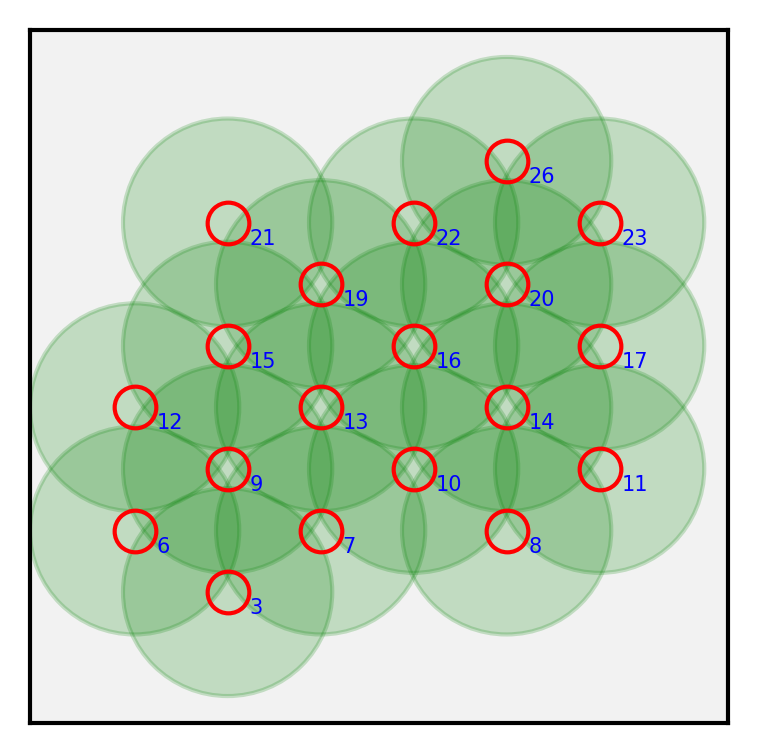

In [19]:
fig = plt.figure(figsize=(3, 3))
drawField(latticeSensors, showSensorLabels=True, showSensorFields=True,
         sensorSize=20, sensorFilled=False)
plt.show()

The basic overhearing structure for these sensors is simply the lattice with edges and triangles as might be expected in such a regular triangulation.

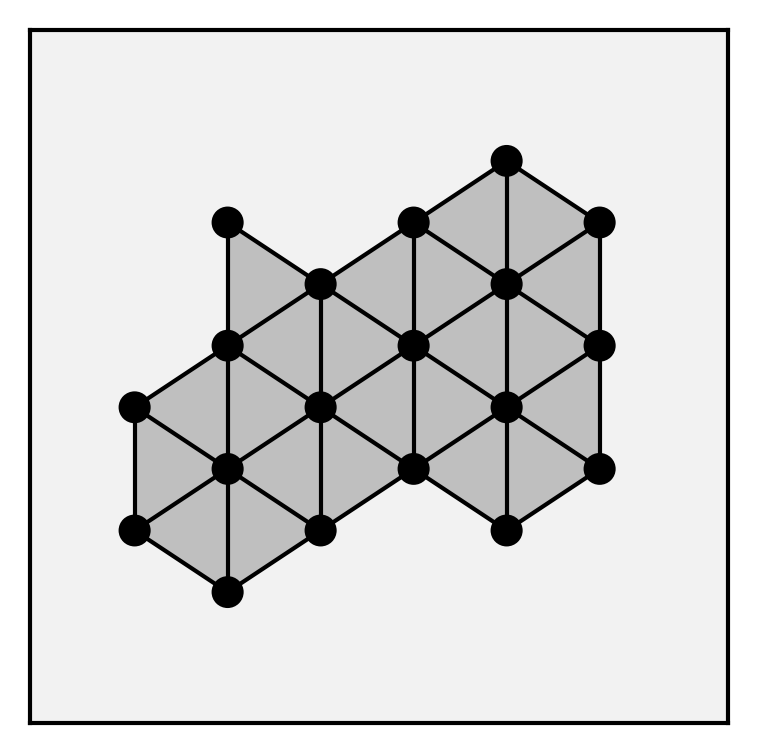

In [20]:
fig = plt.figure(figsize=(3, 3))
drawComplex(lattice, pos)
plt.show()

### Correct counting

We start with a "correct" counting on the lattice, using an Euler integrator. The basic technique is to store the count of each sensor as an attribute on the corresponding 0-simplex of the overhearing complex. 

In [21]:
integrator = EulerIntegrator('count')

These are then propagated to the higher simplices of the complex. A higher simplex has a count that is the minimum of the counts of its faces, which by induction means the minimum count of all the 0-simplices in its basis.

In [22]:
def makeObservations(ss, ts, c, attr = 'count'):
    '''Make obsevrations of targets from sensors and insert
    the counts into the overhearing complex.

    :param ss: the sensors
    :param ts: the targets
    :param c: the complex
    :param attr: the attribute holding the count (default 'count')'''

    # record the counts
    for s in latticeSensors:
        c = s.counts(ts)

        # record the count in an attribute of the overhearing complex
        lattice[s.id()][attr] = c

    # propagate the counts to higher simplices
    for k in range(1, lattice.maxOrder() + 1):
        for s in lattice.simplicesOfOrder(k):
            lattice[s][attr] = min([lattice[f][attr] for f in lattice.faces(s)])

In [23]:
t1 = offset(pos, 15, (0.04, -0.04))
t2 = offset(pos, 16, (-0.04, -0.04))

In [24]:
makeObservations(latticeSensors, [t1, t2], lattice)

We take these obsetvations and plot them, colour-coding the nodes and simplices according to their counts.

In [25]:
col = {}
palette = ['w', 'r', 'b']
for s in latticeSensors:
    col[s.id()] = palette[lattice[s.id()]['count']]

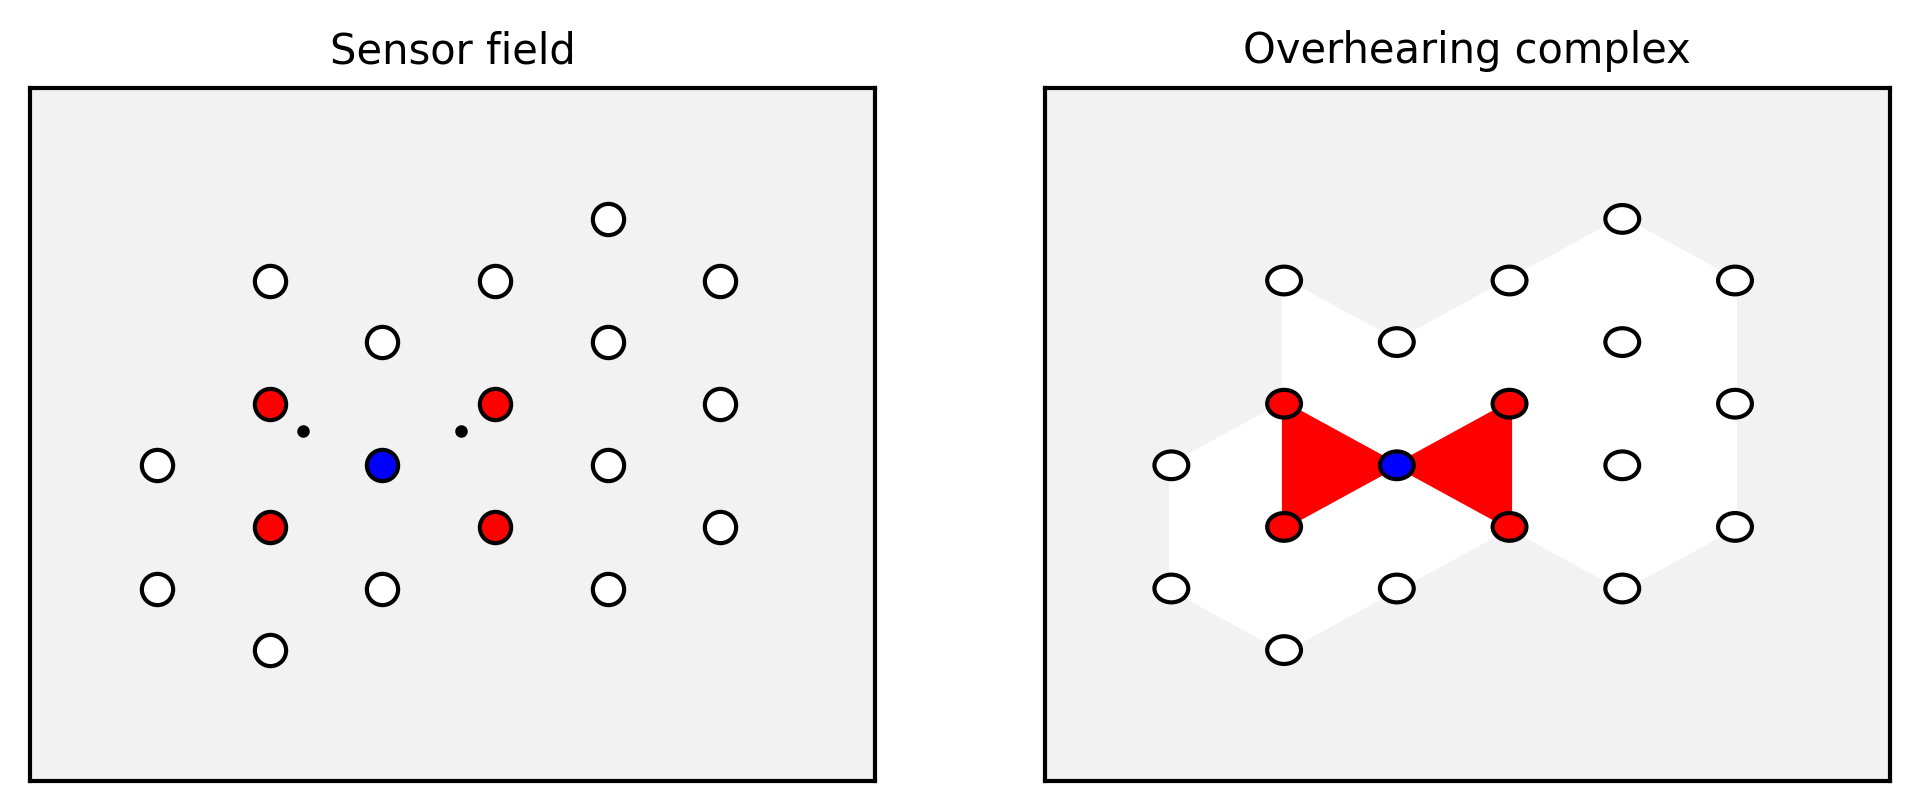

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# draw the sensor field
drawField(latticeSensors, ts=[t1, t2], ax=axs[0],
          showSensorLabels=False, showSensorFields=False,
          showSensors=True, sensorColour='k', sensorSize=15, sensorFilled=True, sensorFillColour=col,
          showTargets=True, targetMarker='o', targetColour='k')
axs[0].set_title('Sensor field')

# draw the overhearing complex
drawComplex(lattice, pos, ax=axs[1],
             simplexColour=lambda c, s, k: palette[lattice[s]['count']])
axs[1].set_title('Overhearing complex')

plt.show()

In [27]:
count = integrator.integrate(lattice)
print(f'Counting {count} targets')

Counting 2 targets


Widely-separated targets can also be correctly counted.

In [28]:
t1 = offset(pos, 15, (0.04, -0.04))
t3 = offset(pos, 20, (0.04, -0.04))

In [29]:
makeObservations(latticeSensors, [t1, t3], lattice)

In [30]:
col = {}
palette = ['w', 'r', 'b']
for s in latticeSensors:
    col[s.id()] = palette[lattice[s.id()]['count']]

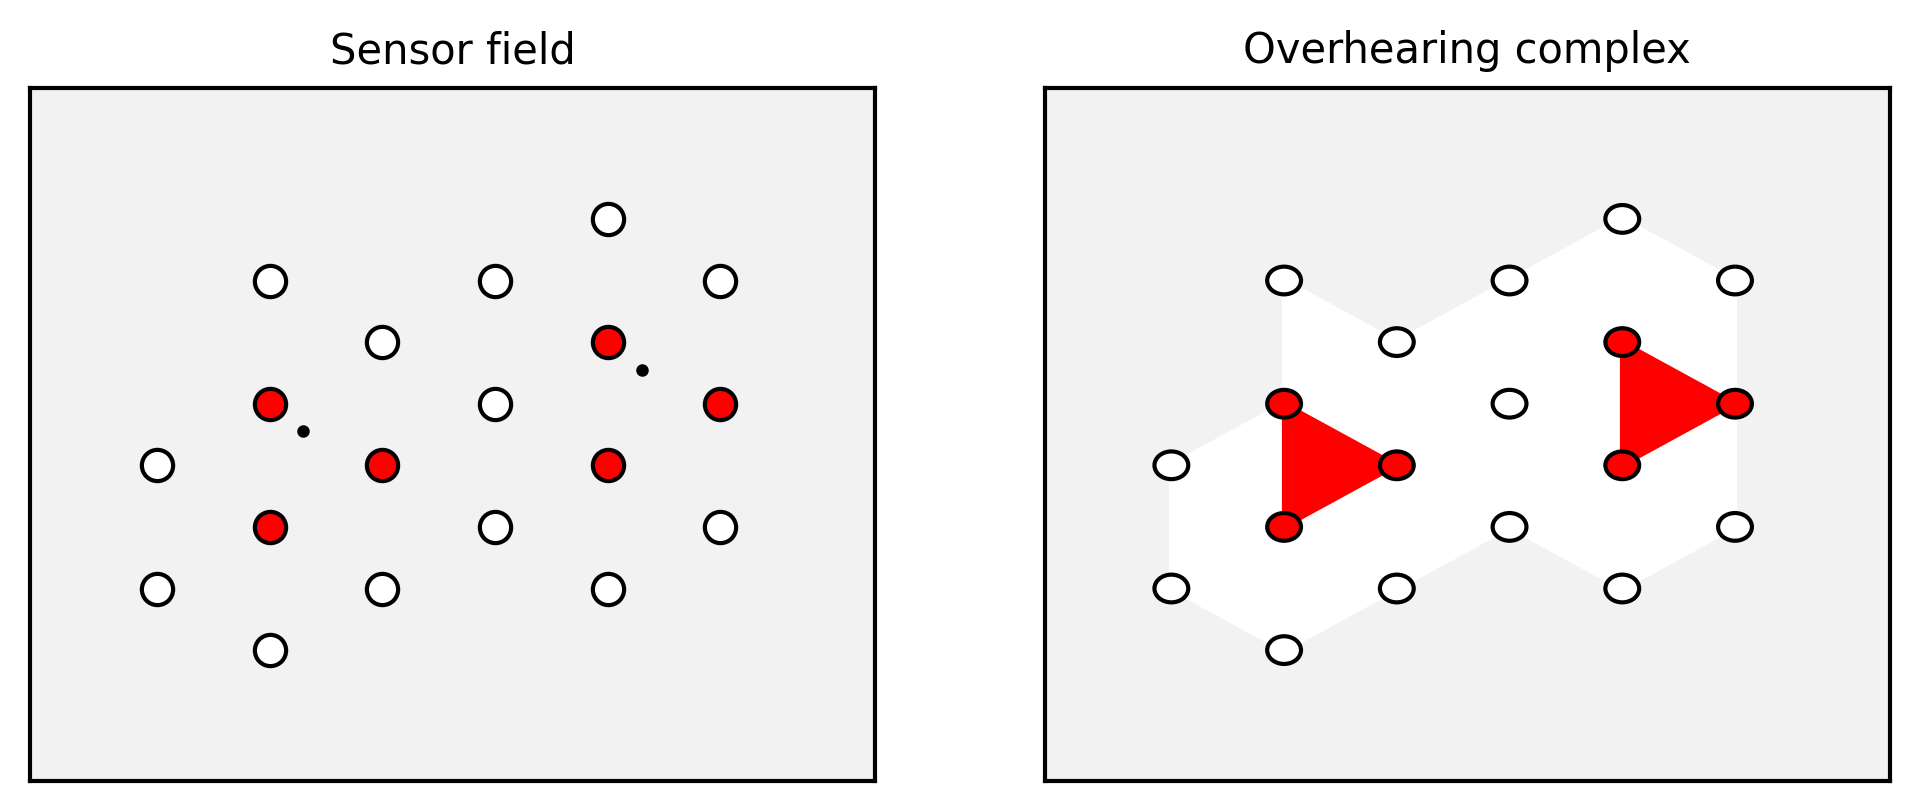

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# draw the sensor field
drawField(latticeSensors, ts=[t1, t3], ax=axs[0],
          showSensorLabels=False, showSensorFields=False,
          showSensors=True, sensorColour='k', sensorSize=15, sensorFilled=True, sensorFillColour=col,
          showTargets=True, targetMarker='o', targetColour='k')
axs[0].set_title('Sensor field')

# draw the overhearing complex
drawComplex(lattice, pos, ax=axs[1],
             simplexColour=lambda c, s, k: palette[lattice[s]['count']])
axs[1].set_title('Overhearing complex')

plt.show()

In [32]:
count = integrator.integrate(lattice)
print(f'Counting {count} targets')

Counting 2 targets


### Incorrect count

However, suppose we spread the targets out so that there is no common sensor seeing them both, but the two sets of observing sensors are adjacent.

In [33]:
t4 = offset(pos, 20, (-0.04, -0.04))

In [34]:
makeObservations(latticeSensors, [t1, t4], lattice)

In [35]:
col = {}
palette = ['w', 'r', 'b']
for s in latticeSensors:
    col[s.id()] = palette[lattice[s.id()]['count']]

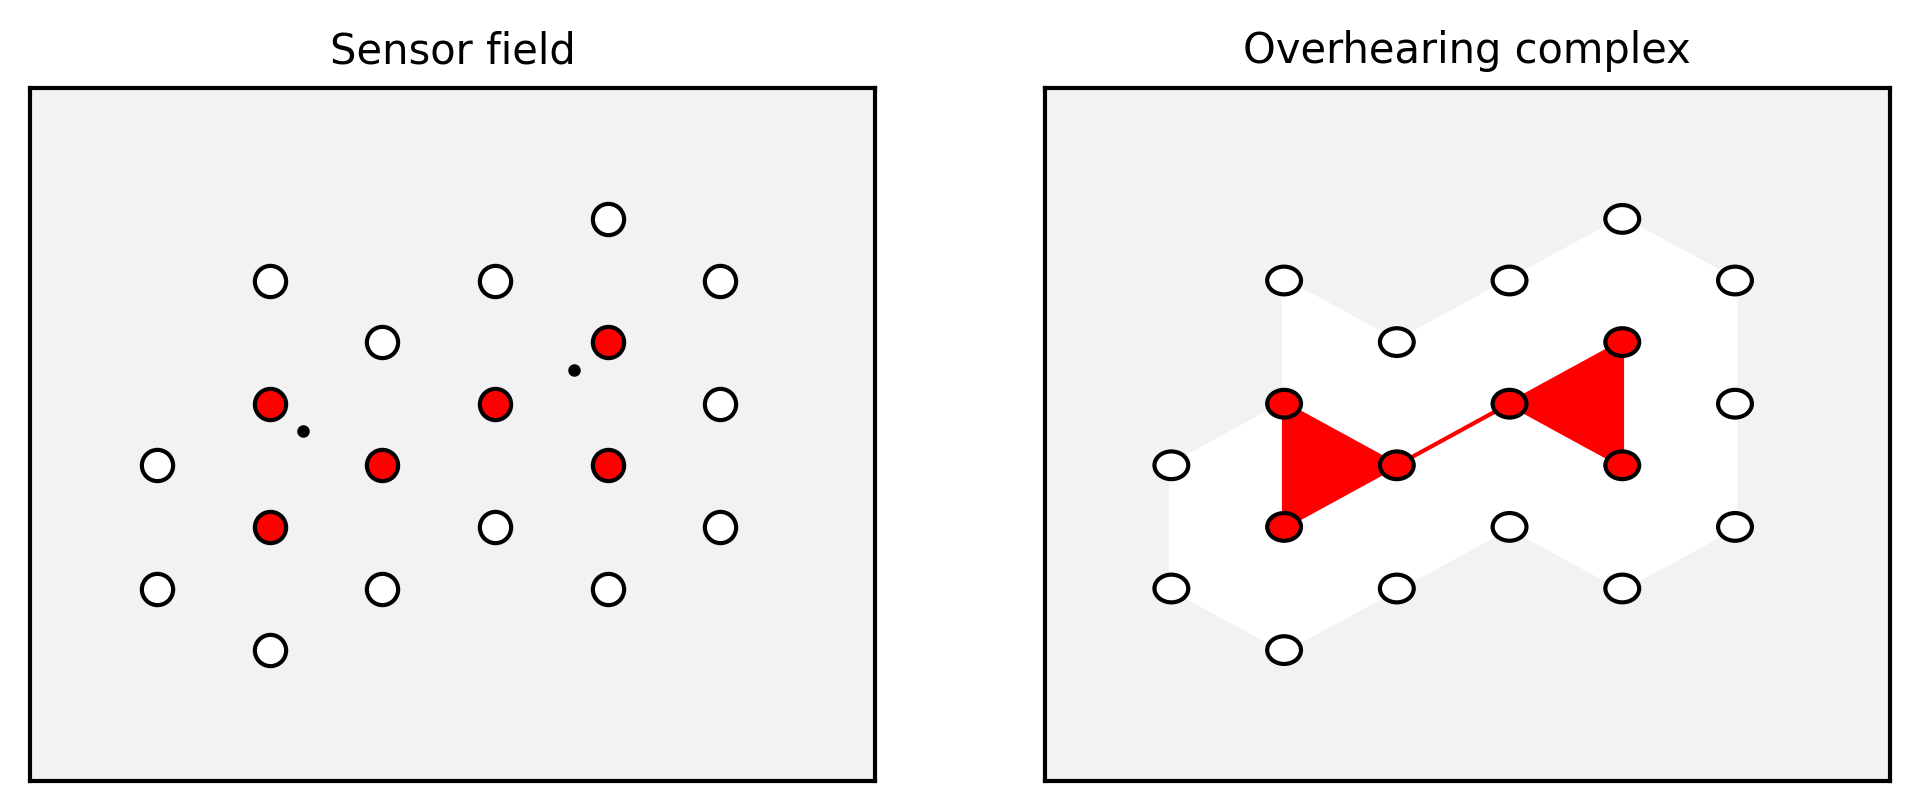

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# draw the sensor field
drawField(latticeSensors, ts=[t1, t4], ax=axs[0],
          showSensorLabels=False, showSensorFields=False,
          showSensors=True, sensorColour='k', sensorSize=15, sensorFilled=True, sensorFillColour=col,
          showTargets=True, targetMarker='o', targetColour='k')
axs[0].set_title('Sensor field')

# draw the overhearing complex
drawComplex(lattice, pos, ax=axs[1],
            simplexColour=lambda c, s, k: palette[lattice[s]['count']])
axs[1].set_title('Overhearing complex')

plt.show()

The method now under-counts the number of targets by 1.

In [37]:
count = integrator.integrate(lattice)
print(f'Counting {count} targets')

Counting 1 targets


### Flooding the landscape

We can see how the incorrect count appears by plotting the stages of the Euler integration.

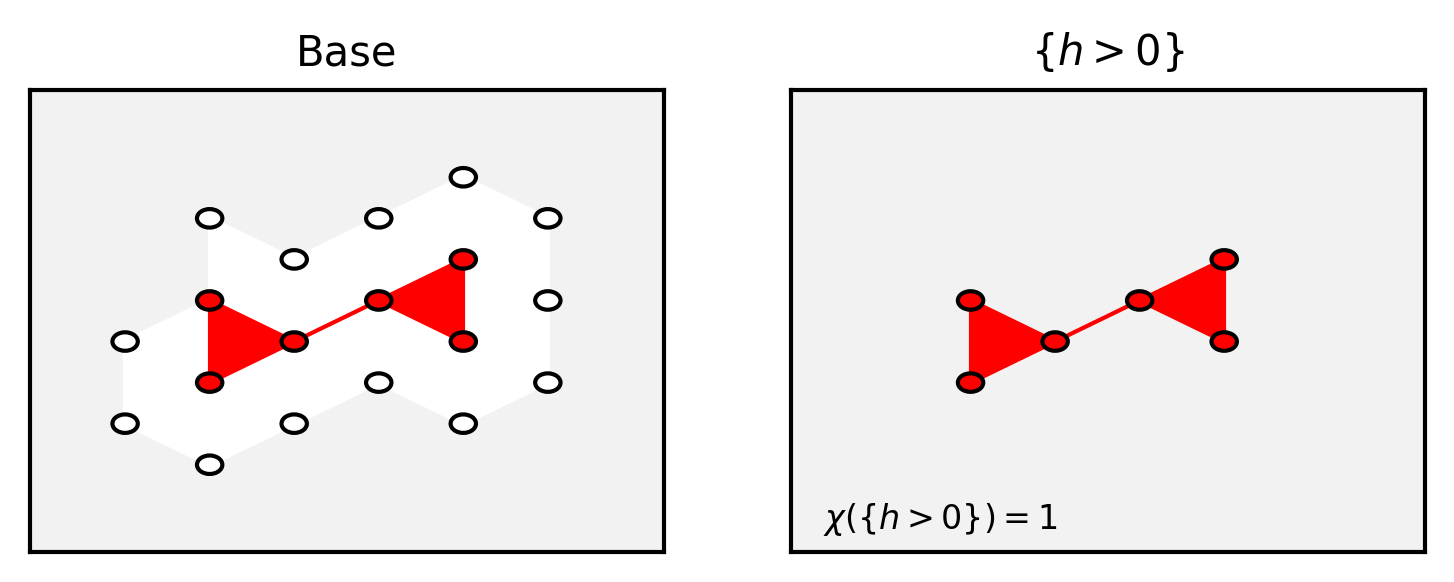

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
drawEulerIntegral(lattice, pos, axs=axs, showLevelSets=True, showEulerCharacteristics=True, simplexColour=lambda c, s, k: palette[lattice[s]['count']])
plt.show()

The level set for $\{h > 0\}$ is now connected &ndash; the two sets of observing sensors have a connecting edge, which takes the minimum of their two counts &ndash; and so has an Euler characteristic of 1. for the non-adjacent observing sets, the Euler characteristic was 2.